In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from ml_toolkit.eda import smooth1D
from scipy import stats
from scipy.special import inv_boxcox
from numpy.random import uniform
from sklearn.preprocessing import RobustScaler
from pandas.api.types import is_numeric_dtype

df = pd.read_csv("housing.csv")

us = uniform(size=len(df))
df_test = df[us>0.8]
df = df[us<=.8]

In [3]:
df.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16536 entries, 0 to 20638
Data columns (total 10 columns):
longitude             16536 non-null float64
latitude              16536 non-null float64
housing_median_age    16536 non-null float64
total_rooms           16536 non-null float64
total_bedrooms        16359 non-null float64
population            16536 non-null float64
households            16536 non-null float64
median_income         16536 non-null float64
median_house_value    16536 non-null float64
ocean_proximity       16536 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [5]:
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16536.000000  16536.000000        16536.000000  16536.000000   
mean    -119.573616     35.636239           28.574262   2647.905721   
std        2.007265      2.135662           12.596237   2194.406330   
min     -124.350000     32.550000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1452.000000   
50%     -118.495000     34.260000           29.000000   2138.500000   
75%     -118.010000     37.720000           37.000000   3154.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population   households  median_income  \
count    16359.000000  16536.000000  16536.00000   16536.000000   
mean       540.399230   1431.440796    501.60075       3.863953   
std        424.591182   1145.109346    384.73712       1.885830   
min          1.000000      3.000000      1.00000       0.499900   
25%        298.000000    791.000000    281.00000       2.566100   
50%        436.000000   1167.000000    411.00000       3.534100   
75%        647.500000   1726.000000    606.00000       4.733875   
max       6445.000000  35682.000000   6082.00000      15.000100   

       median_house_value  
count        16536.000000  
mean        206808.874879  
std         115102.385119  
min          14999.000000  
25%         120000.000000  
50%         179800.000000  
75%         265400.000000  
max         500001.000000

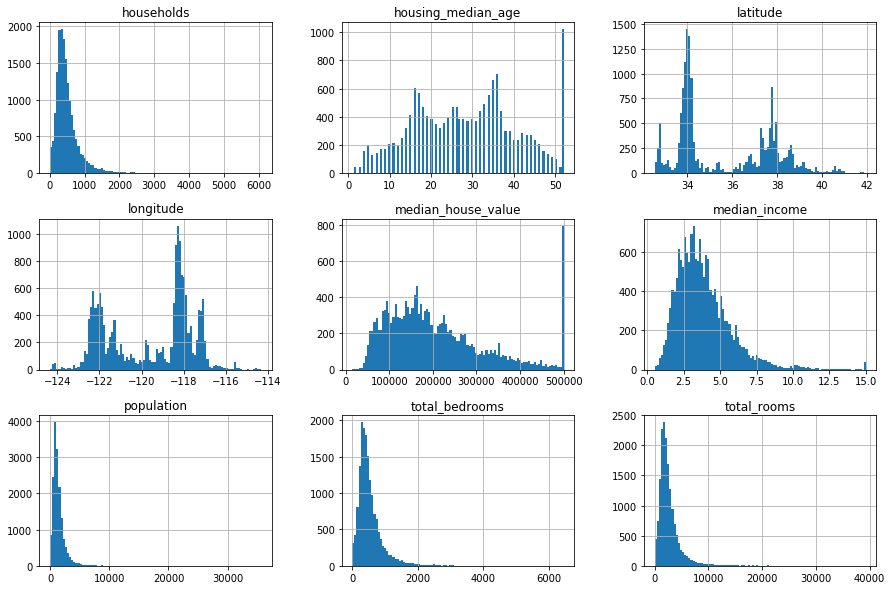

In [6]:
df.hist(bins=100, figsize=(15,10))
plt.show()

In [7]:
class DataManager:
    
    def __init__(self):

        self.bc_exps = {}
        self.scaler = None

    def transform(self, df):
        
        # Clean data
        
        pre_cleaning_len = len(df)
        df = df.query("housing_median_age<52 and median_house_value < 500001").dropna()
        print("Dataframe cleaning: len(df):", pre_cleaning_len, "->", len(df))
        
        # Compute features
        
        ocean_proximity_map = {
            k: j for j, k in enumerate(df.groupby("ocean_proximity").median_house_value.median().sort_values().index)
        }
        
        df["ocean_proximity_"] = df.ocean_proximity.map(ocean_proximity_map)

        df["rooms_per_house"] = df.total_rooms/df.households
        df["bedrooms_per_house"] = df.total_bedrooms/df.households
        df["bedrooms_per_room"] = df.total_bedrooms/df.total_rooms
        
        # Apply BoxCox transformations
        
        for f in df.columns:
            try:
                if f in self.bc_exps.keys():
                    df[f+"_bc"] = stats.boxcox(df[f], lmbda=self.bc_exps[f])
                else:
                    df[f+"_bc"], self.bc_exps[f] = stats.boxcox(df[f])
            except:
                pass
            
        # Scale and eliminate outliers
        num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
        
        if self.scaler is None:
            self.scaler = RobustScaler().fit(X=df[num_cols])
           
        for c in [c+"_S" for c in num_cols]: df[c] = 0
        df[[c+"_S" for c in num_cols]] = self.scaler.transform(df[num_cols])
        
        for f in [c+"_S" for c in num_cols]:
            df[f] = 1/(1+np.exp(-df[f]))-.5
            
        print("Features computed")
        
        print("Dataframe transformed")
        
        return df

dm = DataManager()
df = dm.transform(df)
df.head(10)

Dataframe cleaning: len(df): 16536 -> 14733
Features computed
Dataframe transformed


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0     -122.23     37.88                41.0        880.0           129.0   
1     -122.22     37.86                21.0       7099.0          1106.0   
8     -122.26     37.84                42.0       2555.0           665.0   
18    -122.26     37.84                50.0       2239.0           455.0   
20    -122.27     37.85                40.0        751.0           184.0   
21    -122.27     37.85                42.0       1639.0           367.0   
25    -122.28     37.85                41.0        535.0           123.0   
28    -122.28     37.84                50.0       2082.0           492.0   
30    -122.28     37.84                49.0       1916.0           447.0   
32    -122.27     37.84                48.0       1922.0           409.0   

    population  households  median_income  median_house_value ocean_proximity  \
0        322.0       126.0         8.3252            452600.0        NEAR BAY   
1       2401.0      1138.0         8.3014            358500.0        NEAR BAY   
8       1206.0       595.0         2.0804            226700.0        NEAR BAY   
18       990.0       419.0         1.9911            158700.0        NEAR BAY   
20       409.0       166.0         1.3578            147500.0        NEAR BAY   
21       929.0       366.0         1.7135            159800.0        NEAR BAY   
25       317.0       119.0         2.4038            107500.0        NEAR BAY   
28      1131.0       473.0         1.6424            108900.0        NEAR BAY   
30       863.0       378.0         1.9274            122300.0        NEAR BAY   
32      1026.0       335.0         1.7969            110400.0        NEAR BAY   

    ...  housing_median_age_bc_S  total_rooms_bc_S  total_bedrooms_bc_S  \
0   ...                 0.171561         -0.240937            -0.300175   
1   ...                -0.078964          0.349264             0.283473   
8   ...                 0.182476          0.055317             0.131993   
18  ...                 0.261338          0.012306             0.008546   
20  ...                 0.160427         -0.271682            -0.235745   
21  ...                 0.182476         -0.084562            -0.058585   
25  ...                 0.171561         -0.326015            -0.307541   
28  ...                 0.261338         -0.011010             0.033773   
30  ...                 0.252331         -0.037180             0.002869   
32  ...                 0.243077         -0.036206            -0.025233   

    population_bc_S  households_bc_S  median_income_bc_S  \
0         -0.310338        -0.295081            0.340356   
1          0.221344         0.312503            0.339534   
8          0.000000         0.117906           -0.189842   
18        -0.061193         0.001553           -0.203245   
20        -0.272199        -0.245729           -0.299721   
21        -0.080038        -0.041578           -0.245372   
25        -0.312588        -0.304025           -0.142211   
28        -0.020304         0.041374           -0.256232   
30        -0.101249        -0.031444           -0.212857   
32        -0.050404        -0.068799           -0.232659   

    median_house_value_bc_S  rooms_per_house_bc_S  bedrooms_per_house_bc_S  \
0                  0.312086              0.215132                -0.069035   
1                  0.247103              0.140064                -0.215527   
8                  0.096344             -0.159931                 0.166195   
18                -0.025543              0.020304                 0.095809   
20                -0.049490             -0.117836                 0.146889   
21                -0.023255             -0.126178                -0.129225   
25                -0.145089             -0.122968                -0.041343   
28                -0.141469             -0.140142                -0.023059   
30                -0.107839             -0.023351                 0.276423   
32      

# Feature exploration

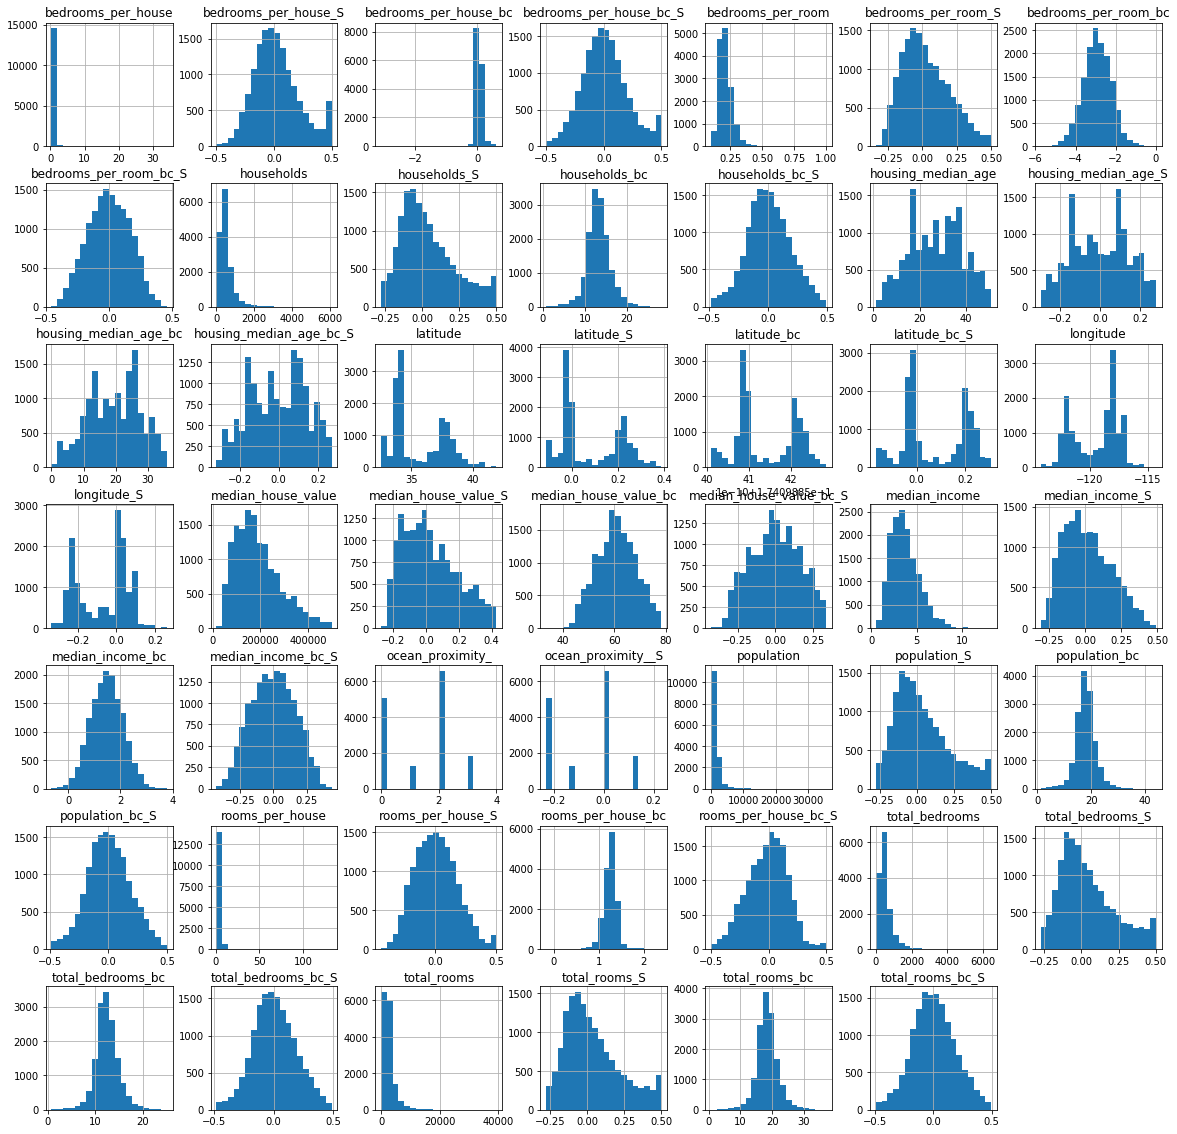

In [8]:
df.hist(bins=20, figsize=(20,20))
plt.show()

In [9]:
df.corr().median_house_value.abs().sort_values(ascending=False).index

Index(['median_house_value', 'median_house_value_S', 'median_house_value_bc',
       'median_house_value_bc_S', 'median_income', 'median_income_S',
       'median_income_bc_S', 'median_income_bc', 'ocean_proximity_',
       'ocean_proximity__S', 'bedrooms_per_room_bc', 'bedrooms_per_room_bc_S',
       'bedrooms_per_room_S', 'rooms_per_house_S', 'bedrooms_per_room',
       'rooms_per_house_bc_S', 'total_rooms_bc_S', 'total_rooms_S',
       'rooms_per_house_bc', 'total_rooms_bc', 'latitude', 'latitude_S',
       'total_rooms', 'latitude_bc', 'latitude_bc_S', 'bedrooms_per_house_S',
       'bedrooms_per_house_bc_S', 'households_bc_S', 'households_S',
       'households_bc', 'bedrooms_per_house_bc', 'rooms_per_house',
       'households', 'total_bedrooms_bc_S', 'total_bedrooms_S',
       'total_bedrooms_bc', 'total_bedrooms', 'bedrooms_per_house',
       'population_bc', 'population_bc_S', 'longitude', 'population_S',
       'longitude_S', 'population', 'housing_median_age_S',
       'hous

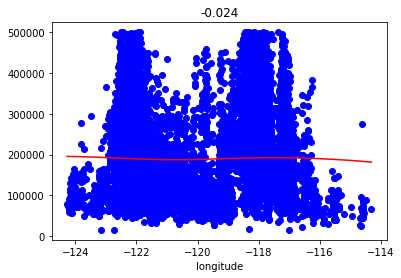

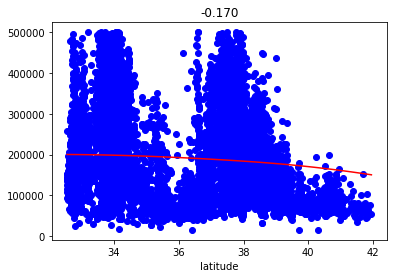

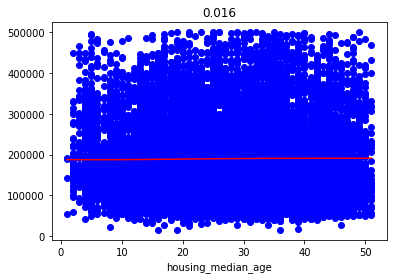

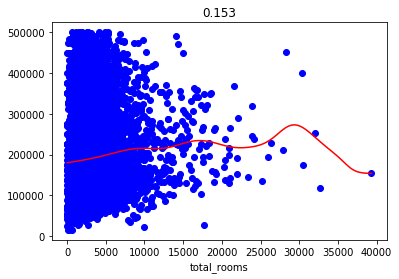

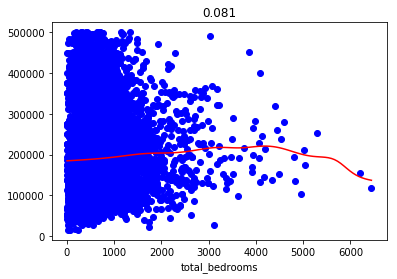

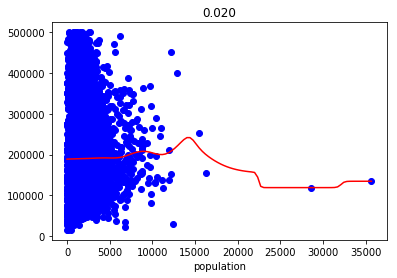

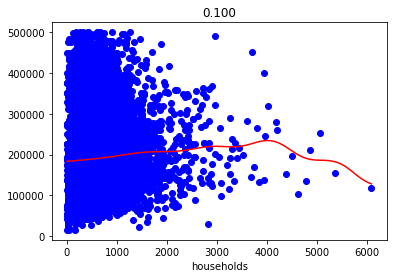

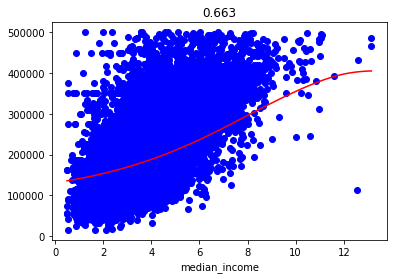

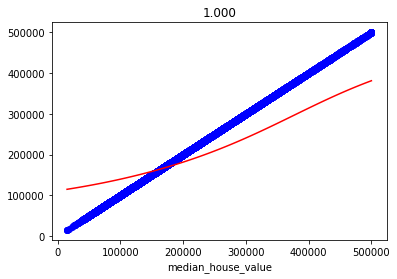

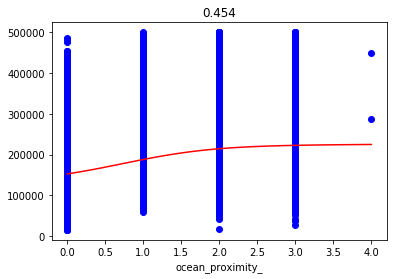

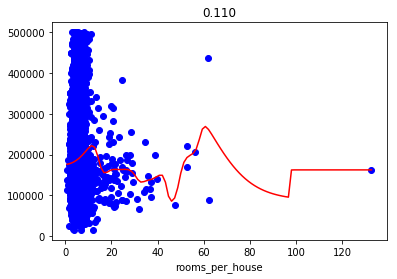

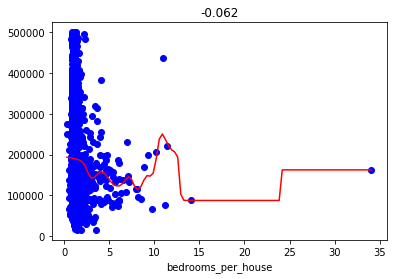

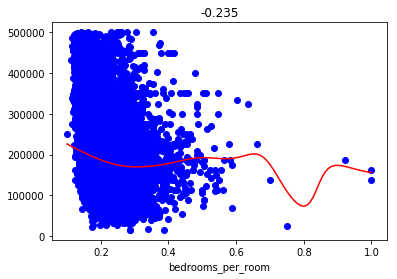

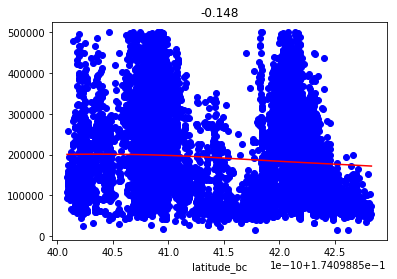

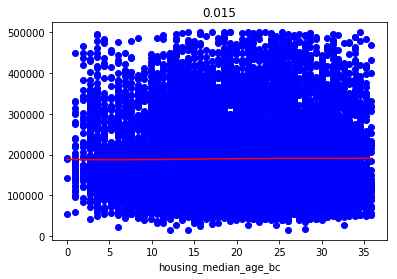

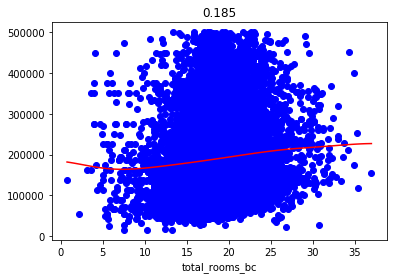

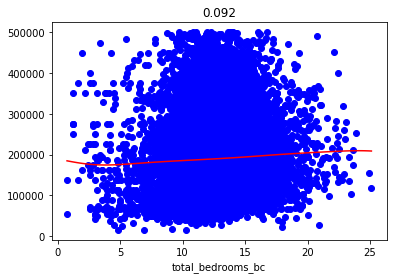

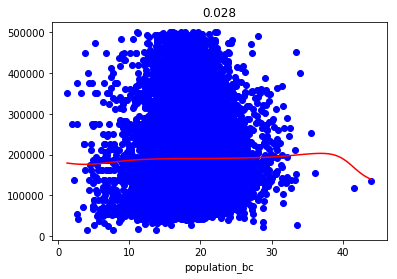

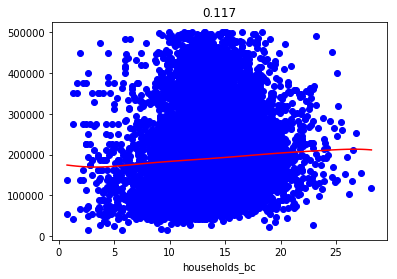

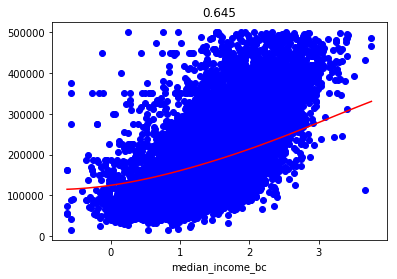

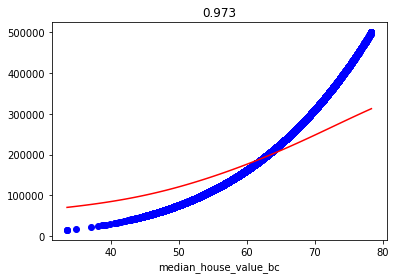

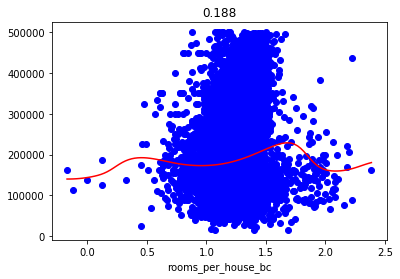

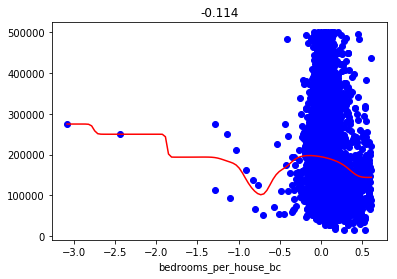

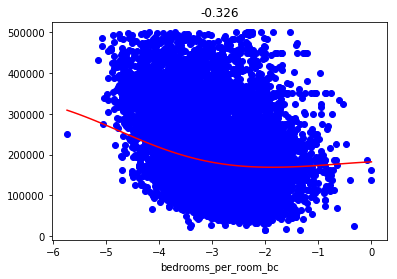

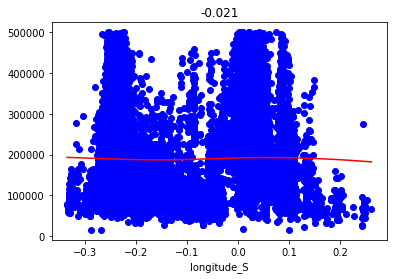

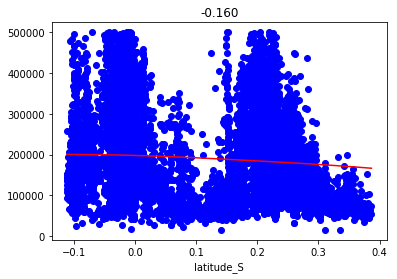

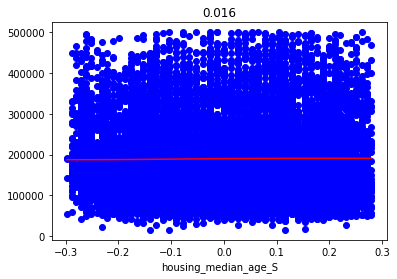

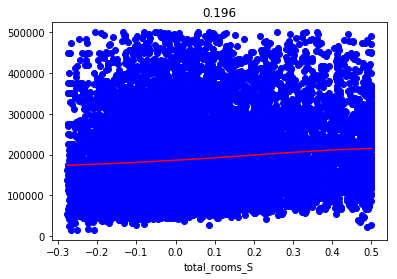

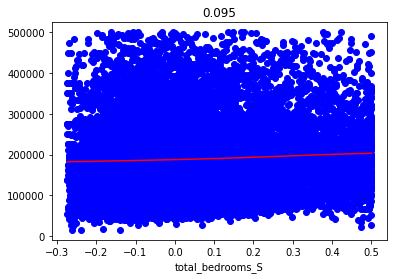

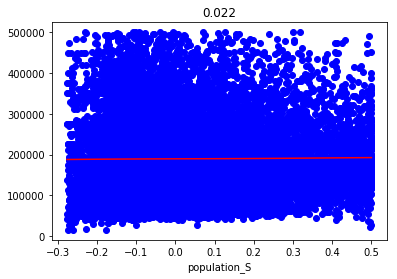

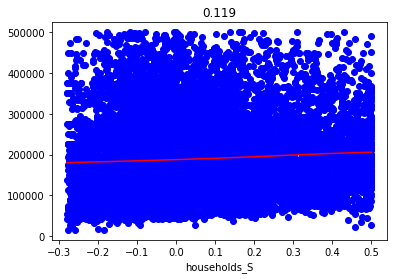

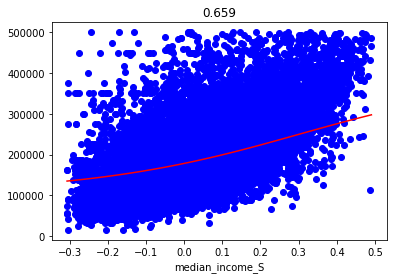

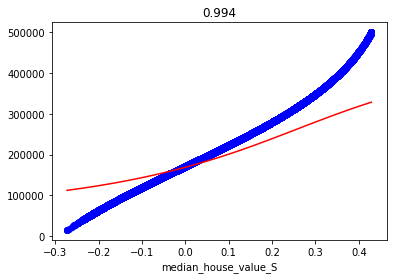

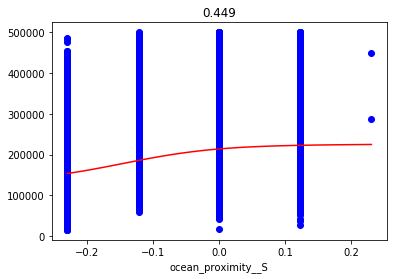

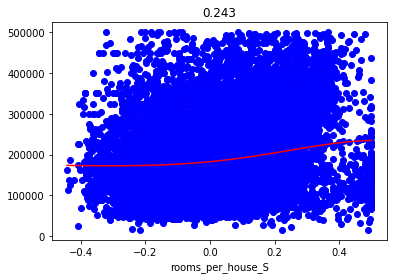

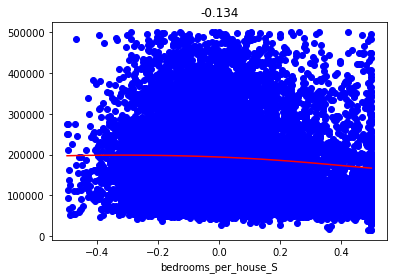

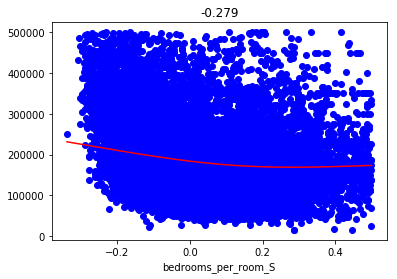

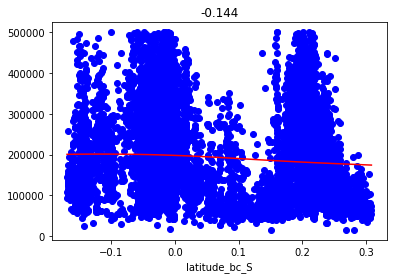

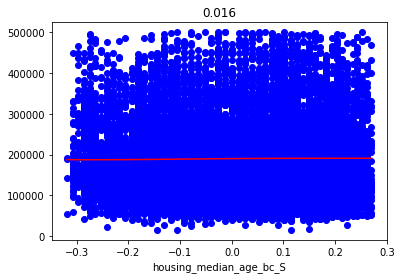

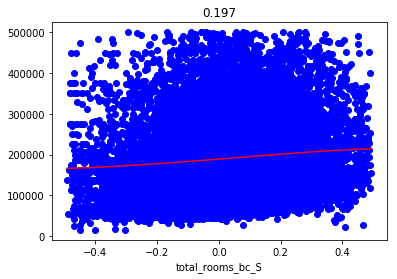

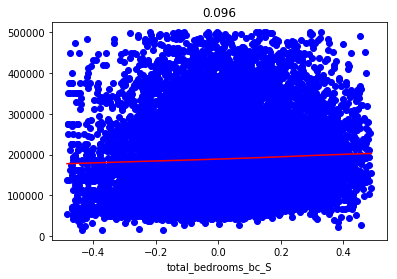

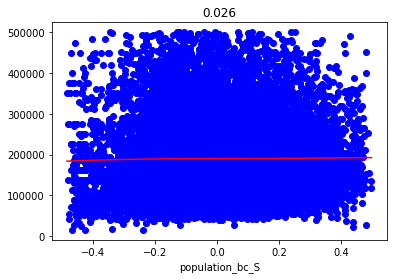

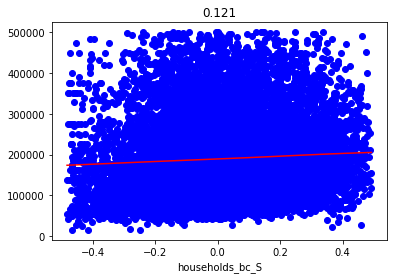

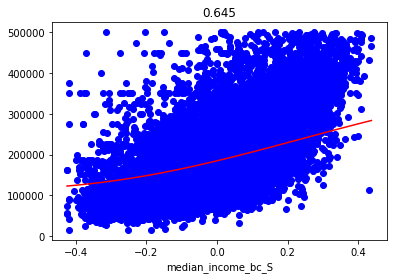

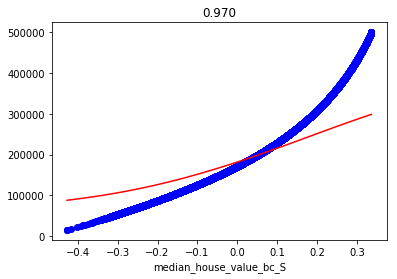

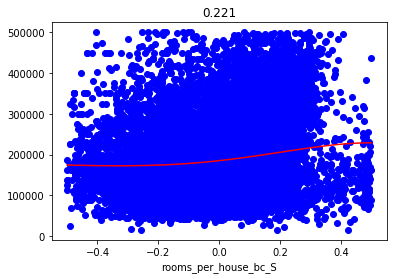

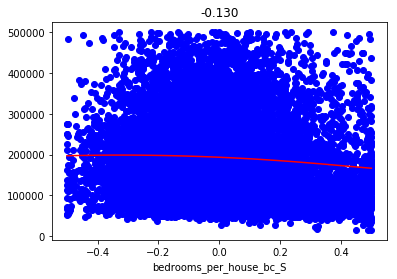

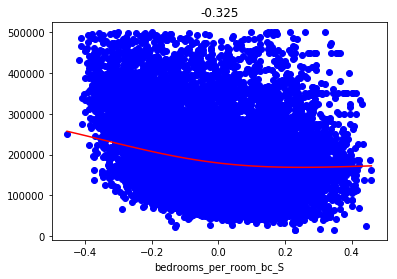

In [10]:
for f in df.columns:
    try:
        x, y = df[f], df.median_house_value
        xs, ys = smooth1D(x, y)
        plt.figure()
        plt.plot(x, y, 'bo')
        plt.plot(xs, ys, 'r-')
        plt.xlabel(f)
        plt.title("%.3f"%np.corrcoef(x, y)[0,1])
        plt.show()
        
    except:
        pass

# Linear regression

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

features = [
    "bedrooms_per_room_bc_S", 
    "ocean_proximity_", 
    "median_income_bc_S",
    "latitude",
    "longitude",
]
target = "median_house_value_bc"

X, y = df[features].values, df[target].values

reg = LinearRegression().fit(X, y)
cv_scores = cross_val_score(reg, X, y, cv=10)
print("cv_score:", "%.2f"%(100*np.mean(cv_scores)), "+-", "%.2f"%(100*np.std(cv_scores)))

cv_score: 49.45 +- 14.64


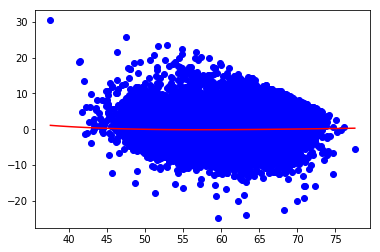

In [12]:
y_hat = reg.predict(X)
xs, ys = smooth1D(y_hat, y-y_hat)
plt.plot(y_hat, y-y_hat, "bo")
plt.plot(xs, ys, "r-")

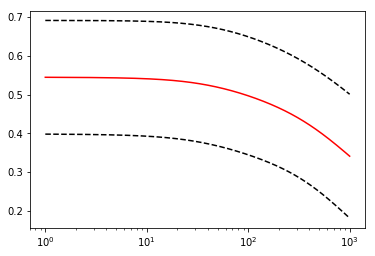

In [13]:
from sklearn.linear_model import Ridge

alphas = np.logspace(0,3,1000)
cv_scores_mean = []; cv_scores_std = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=0)
    cvs = cross_val_score(ridge, X, y, cv=5)
    cv_scores_mean.append(np.mean(cvs))
    cv_scores_std.append(np.std(cvs))
cv_scores_mean = np.array(cv_scores_mean); cv_scores_std = np.array(cv_scores_std)
    
plt.semilogx(alphas, cv_scores_mean, 'r-')
plt.semilogx(alphas, cv_scores_mean+cv_scores_std, 'k--')
plt.semilogx(alphas, cv_scores_mean-cv_scores_std, 'k--')

In [14]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(cv=5, alphas=np.logspace(-10,1,100)).fit(X, y)
cv_scores = cross_val_score(ridge, X, y, cv=10)
print("alpha:", ridge.alpha_)
print("cv_score:", "%.2f"%(100*np.mean(cv_scores)), "+-", "%.2f"%(100*np.std(cv_scores)))
# ridge.score(X, y)

alpha: 1e-10
cv_score: 49.45 +- 14.64


In [15]:
from sklearn.ensemble import RandomForestRegressor

features = [
#     "bedrooms_per_room_bc_S", 
    "ocean_proximity_", 
    "median_income_bc_S",
    "longitude",
    "latitude",
]
target = "median_house_value_bc"

X, y = df[features].values, df[target].values

params = {
    "n_estimators": 100, 
    "max_features": "sqrt", 
    "max_depth": 4, 
    "oob_score": True, 
    "random_state": 0, 
    "max_samples": .8    
}

rf = RandomForestRegressor(**params).fit(X,y)

cv_scores = cross_val_score(rf, X, y, cv=5)
print("cv_score:", "%.2f"%(100*np.mean(cv_scores)), "+-", "%.2f"%(100*np.std(cv_scores)), "\n")

for f, fi in zip(features, rf.feature_importances_):
    print(f, fi)

cv_score: 51.86 +- 17.18 

ocean_proximity_ 0.40972851282620826
median_income_bc_S 0.4621912111471437
longitude 0.0519154045788865
latitude 0.0761648714477615


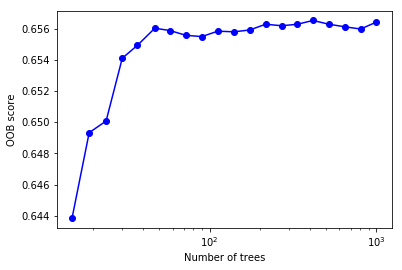

In [16]:
cv_scores = []
n_est_grid = [int(x) for x in np.logspace(1.2, 3, 20)]

for n in n_est_grid:
    params.update({"n_estimators": n})
    rf = RandomForestRegressor(**params).fit(X, y)
    cv_scores.append(rf.oob_score_)
    
plt.semilogx(n_est_grid, cv_scores, "bo-")
plt.xlabel("Number of trees"); plt.ylabel("OOB score"); plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV


gs = GridSearchCV(estimator=rf, param_grid={"n_estimators": [100], "max_depth": [2, 4, 6], "max_features": ["auto", "sqrt"]}, cv=5).fit(X, y)
gs.best_estimator_

RandomForestRegressor(max_depth=6, max_features='sqrt', max_samples=0.8,
                      oob_score=True, random_state=0)

In [18]:
gs.score(X, y)

0.7278953776442125

In [19]:
gs.cv_results_

{'mean_fit_time': array([0.51952758, 0.35210009, 0.73530707, 0.53307247, 1.01917086,
        0.61666098]),
 'mean_score_time': array([0.01262236, 0.01210408, 0.01478691, 0.01577606, 0.01796241,
        0.01711206]),
 'mean_test_score': array([0.42796773, 0.40912884, 0.52898966, 0.51861384, 0.52997885,
        0.55153545]),
 'param_max_depth': masked_array(data=[2, 2, 4, 4, 6, 6],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'sqrt', 'auto', 'sqrt', 'auto', 'sqrt'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 100, 100, 100, 100, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100},
  {'max_depth': 2, 'max_features'

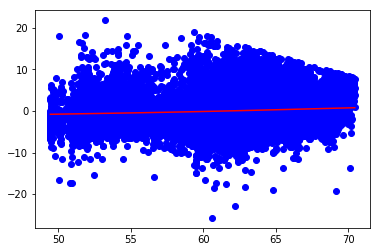

In [20]:
y_hat = rf.predict(X)
xs, ys = smooth1D(y_hat, y-y_hat)
plt.plot(y_hat, y-y_hat, "bo")
plt.plot(xs, ys, "r-")

In [22]:
from sklearn.ensemble import StackingRegressor

sr = StackingRegressor(estimators=[
    ("1", reg),
    ("2", gs.best_estimator_),
], cv=5).fit(X, y)

In [25]:
sr.final_estimator_.coef_

array([0.38048248, 0.69003452])

In [26]:
sr.score(X, y)

0.7107440431211318

# Final evaluation

In [ ]:
df_test = dm.transform(df_test)

In [ ]:
len(df_test)

In [ ]:
X_test, y_test = df_test[features].values, df_test[target].values
est.score(X_test, y_test)

In [ ]:
from sklearn.metrics import r2_score

y_test_hat = inv_boxcox(est.predict(X_test), dm.bc_exps['median_house_value'])

r2_score(df_test.median_house_value, y_test_hat)

In [ ]:
xs, ys = smooth1D(y_test_hat, df_test.median_house_value-y_test_hat)
plt.plot(y_test_hat, df_test.median_house_value-y_test_hat, "bo")
plt.plot(xs, ys, "r-")

In [ ]:
plt.hist(df_test.median_house_value-y_test_hat, bins=50)
plt.show()

In [ ]:
100*np.std(df_test.median_house_value-y_test_hat)/df_test.median_house_value.mean()